<a href="https://colab.research.google.com/github/PIRATES7376/Computer-Vision-and-Pattern-Recognition--CVPR/blob/main/CVPR_mid_Assignment_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Loaded dataset with 300 samples and 3 classes.
class cat -> label 0: 100 samples
class dog -> label 1: 100 samples
class panda -> label 2: 100 samples
Fold 1 | k=01 | acc=0.3833
Fold 1 | k=02 | acc=0.3667
Fold 1 | k=03 | acc=0.3500
Fold 1 | k=04 | acc=0.3667
Fold 1 | k=05 | acc=0.3667
Fold 1 | k=06 | acc=0.3667
Fold 1 | k=07 | acc=0.4000
Fold 1 | k=08 | acc=0.3500
Fold 1 | k=09 | acc=0.3500
Fold 1 | k=10 | acc=0.3667
Fold 1 | k=11 | acc=0.4167
Fold 1 | k=12 | acc=0.4167
Fold 1 | k=13 | acc=0.4333
Fold 1 | k=14 | acc=0.3500
Fold 1 | k=15 | acc=0.3833
Fold 1 | k=16 | acc=0.3333
Fold 1 | k=17 | acc=0.3500
Fold 1 | k=18 | acc=0.3667
Fold 1 | k=19 | acc=0.3667
Fold 1 | k=20 | acc=0.3333
Fold 2 | k=01 | acc=0.4000
Fold 2 | k=02 | acc=0.4167
Fold 2 | k=03 | acc=0.4167
Fold 2 | k=04 | acc=0.4167
Fold 2 | k=05 | acc=0.3667
Fold 2 | k=06 | acc=0.4000
Fold 2 | k=07 | acc=0.4833
Fold 2 | k=08 | acc=0.4833
Fold 2 | k=09 | acc=0.5333
Fold 2 | k=10 | acc=0.4667
Fold 2 | k=11

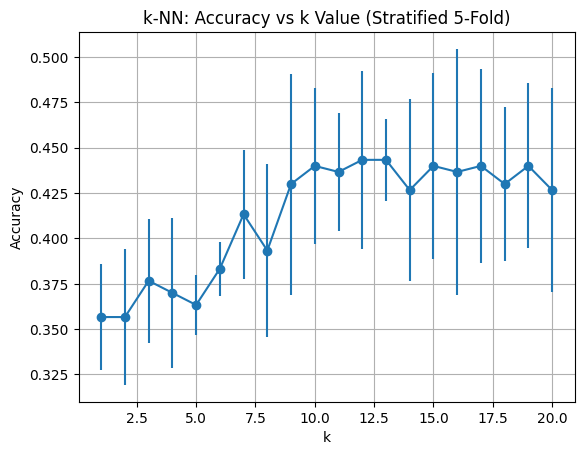

Best k: 12


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from PIL import Image

np.random.seed(42)
IMG_SIZE = (32, 32)
TARGET_TOKENS = ["dog", "cat", "panda"]
PER_CLASS = 100
N_SPLITS = 5
K_CHOICES = range(1, 21, 1)

def list_images(d):
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff")
    files = []
    for e in exts:
        files += glob.glob(os.path.join(d, e))
    return sorted(files)

def preprocess_image(image_np, size=(32, 32)):
    img = Image.fromarray(image_np) if not isinstance(image_np, Image.Image) else image_np
    img = img.convert('L').resize(size, Image.BILINEAR)
    arr = np.asarray(img, dtype=np.float32) / 255.0
    return arr.reshape(-1)

def find_class_dirs(dataset_dir, tokens):
    tokens = [t.lower() for t in tokens]
    mapping = {}
    for name in os.listdir(dataset_dir):
        p = os.path.join(dataset_dir, name)
        if not os.path.isdir(p):
            continue
        lname = name.lower()
        for t in tokens:
            if t in lname and t not in mapping:
                mapping[t] = p
    missing = [t for t in tokens if t not in mapping]
    if missing:
        raise RuntimeError(f"Missing class folders for: {missing}. Found={mapping}")
    return mapping

def load_dataset(dataset_dir):
    """Load exactly 100 images per target class, return X (float32), y (int64), class_map."""
    class_dirs = find_class_dirs(dataset_dir, TARGET_TOKENS)
    classes = sorted(class_dirs.keys())
    class_map = {cls: idx for idx, cls in enumerate(classes)}
    data, labels = [], []

    for cls in classes:
        cls_dir = class_dirs[cls]
        imgs = list_images(cls_dir)
        if len(imgs) < PER_CLASS:
            raise RuntimeError(f"Class '{cls}' has {len(imgs)} images (< {PER_CLASS}).")
        imgs = imgs[:PER_CLASS]
        for img_path in imgs:
            try:
                img_np = np.array(Image.open(img_path))
                feat = preprocess_image(img_np, size=IMG_SIZE)
                data.append(feat)
                labels.append(class_map[cls])
            except Exception as e:
                print(f"Could not process image {img_path}: {e}")

    X = np.asarray(data, dtype=np.float32)
    y = np.asarray(labels, dtype=np.int64)
    return X, y, class_map

class KNearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):

        self.X_train = X.astype(np.float32, copy=False)
        self.y_train = y.astype(np.int64,   copy=False)

    def compute_distances(self, X):

        X = X.astype(np.float32, copy=False)
        X2 = np.sum(X**2, axis=1, keepdims=True)
        Y2 = np.sum(self.X_train**2, axis=1, keepdims=True).T
        XY = X @ self.X_train.T
        d2 = X2 + Y2 - 2.0 * XY
        np.maximum(d2, 0, out=d2)
        return d2

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test, dtype=np.int64)
        for i in range(num_test):
            nearest = np.argsort(dists[i])[:k]
            closest_y = self.y_train[nearest]
            vals, cnts = np.unique(closest_y, return_counts=True)
            y_pred[i] = vals[np.argmax(cnts)]
        return y_pred

    def predict(self, X, k=1):
        dists = self.compute_distances(X)
        return self.predict_labels(dists, k)


dataset_dir = "/content/drive/MyDrive/CVPR/train"

X, y, class_map = load_dataset(dataset_dir)
print(f"Loaded dataset with {len(X)} samples and {len(class_map)} classes.")
for cls, idx in sorted(class_map.items(), key=lambda kv: kv[1]):
    print(f"class {cls} -> label {idx}: {(y==idx).sum()} samples")

kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
k_to_accuracies = {k: [] for k in K_CHOICES}

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    knn = KNearestNeighbor()
    knn.train(X_train, y_train)

    for k in K_CHOICES:
        y_val_pred = knn.predict(X_val, k=k)
        acc = float(np.mean(y_val_pred == y_val))
        k_to_accuracies[k].append(acc)
        print(f"Fold {fold} | k={k:02d} | acc={acc:.4f}")

mean_accuracies = [np.mean(k_to_accuracies[k]) for k in K_CHOICES]
std_accuracies  = [np.std(k_to_accuracies[k])  for k in K_CHOICES]

for k, m in zip(K_CHOICES, mean_accuracies):
    print(f"K = {k},  Average Accuracy (Mean)  = {m:.4f}")

plt.errorbar(list(K_CHOICES), mean_accuracies, yerr=std_accuracies, fmt='-o')
plt.title("k-NN: Accuracy vs k Value (Stratified 5-Fold)")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

best_k = list(K_CHOICES)[int(np.argmax(mean_accuracies))]
print(f"Best k: {best_k}")